#Predição do gênero de uma música a partir da letra

###Esse projeto tem como objetivo construir um modelo que prevê o gênero de uma música a partir da letra dela, utilizando um modelo de Processamento de Linguagem Natural (PLN), ou em ingles Natural Language Processing (NLP), e o dataset abaixo:
https://www.kaggle.com/neisse/scrapped-lyrics-from-6-genres

###Esse dataset contêm dois arquivos. O primeiro, artists-data, contém as seguintes colunas:
- Artists (nome do artista)
- Songs (quantidade de musicas)
- Popularity (nota de popularidade)
- Link (link da página do artista)
- Genre (gênero principal)
- Genres (gêneros que o artista de encaixa)

###O segundo dataset, lyrics-data, contém as seguintes colunas:
- ALink (link da página do artista)
- SName (nome da música)
- SLink (link da página da música)
- Lyric (letra da música)
- Idiom (idioma da música)

Primeiro faremos a conexão com o Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
caminho_drive = '/content/drive/My Drive/colab/NLP/T2/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Depois vamos importar as bibliotecas que serão utilizadas ao longo do código.

In [2]:
import pandas as pd
import nltk
nltk.download( 'popular' )
nltk.download( 'rslp' )
from nltk.stem import RSLPStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
agora = str( datetime.now() - timedelta(hours = 3) ).replace(' ', '_').replace('-', '').replace(':', '')[:15] #horario de brasilia UTC-3
caminho_export = '{0}{1}_'.format( caminho_drive, agora )

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

Using TensorFlow backend.


In [3]:
print('{0} -> inicio'.format(datetime.now() - timedelta(hours = 3)))
inicio = time.time()

artistas = pd.read_csv( caminho_drive + 'artists-data.csv' )
letras = pd.read_csv( caminho_drive + 'lyrics-data.csv' )

artistas = artistas[['Artist', 'Link', 'Genre']]
letras = letras[['ALink', 'SName', 'Lyric', 'Idiom']]
dataset = pd.merge( artistas, letras, left_on='Link', right_on='ALink' )
dataset = dataset[['Artist', 'Genre', 'SName', 'Lyric', 'Idiom']]

labels = dataset['Genre'].unique()

dataset_generos = { 'Rock':0, 'Pop':1, 'Hip Hop':2, 'Sertanejo':3, 'Samba':4, 'Funk Carioca':5 }
dataset_generos_rev = { 0:'Rock', 1:'Pop', 2:'Hip Hop', 3:'Sertanejo', 4:'Samba', 5:'Funk Carioca' }
dataset['NR_Genre'] = dataset['Genre']
dataset['NR_Genre'].replace( dataset_generos, inplace=True )

dataset_pt = dataset[dataset['Idiom'] == 'PORTUGUESE']
dataset_en = dataset[dataset['Idiom'] == 'ENGLISH']
dataset_en = dataset_en[(dataset_en['Genre'] == 'Rock') | (dataset_en['Genre'] == 'Pop') | (dataset_en['Genre'] == 'Hip Hop')]

quantidade_generos_pt = 6
quantidade_generos_en = 3

print('{0} -> fim , levou {1:.2f}s'.format(datetime.now() - timedelta(hours = 3), time.time() - inicio))

2020-06-27 17:12:20.861636 -> inicio
2020-06-27 17:12:26.897560 -> fim , levou 6.04s


#PT

In [4]:
print('{0} -> inicio'.format(datetime.now() - timedelta(hours = 3)))
inicio = time.time()

letras_pt_agrupado = ''
for i in range( dataset_pt.shape[0] ):
    letras_pt_agrupado += dataset_pt.iloc[i]['Lyric']

w_token_pt = word_tokenize( letras_pt_agrupado )

print('{0} -> fim , levou {1:.2f}s'.format(datetime.now() - timedelta(hours = 3), time.time() - inicio))

2020-06-27 17:12:26.912585 -> inicio
2020-06-27 17:16:27.666891 -> fim , levou 240.75s


In [5]:
print('{0} -> inicio'.format(datetime.now() - timedelta(hours = 3)))
inicio = time.time()

stw_pt = stopwords.words('portuguese')
pontuacao = list( punctuation )
stopwords_pt = set( stw_pt + pontuacao ) #cria lista sem repetir elementos
w_token_pt_sem_stopwords = [palavra for palavra in w_token_pt if palavra not in stopwords_pt]

stemmer = RSLPStemmer()
w_token_pt_sem_stopwords_stem = [stemmer.stem( palavra ) for palavra in w_token_pt_sem_stopwords]

print('{0} -> fim , levou {1:.2f}s'.format(datetime.now() - timedelta(hours = 3), time.time() - inicio))

2020-06-27 17:16:27.683174 -> inicio
2020-06-27 17:23:11.718779 -> fim , levou 404.04s


In [1]:
print('{0} -> inicio'.format(datetime.now() - timedelta(hours = 3)))
inicio = time.time()

vectorizer_pt = CountVectorizer( analyzer='word', max_features=30000 )
vectorizer_pt.fit( w_token_pt_sem_stopwords_stem )
tamanho_dicionario_pt = len(list(vectorizer_pt.vocabulary_))

letras_pt = dataset_pt['Lyric'].values #X
generos_pt = dataset_pt['NR_Genre'].values #Y

generos_pt_dummy = np_utils.to_categorical(generos_pt)

x_treino_pt, x_teste_pt, y_treino_pt, y_teste_pt = train_test_split( letras_pt, generos_pt_dummy, test_size=0.3, random_state=42 )
x_vali_pt, x_teste_pt, y_vali_pt, y_teste_pt = train_test_split( x_teste_pt, y_teste_pt, test_size=0.5, random_state=42 )

BOW_x_treino_pt = vectorizer_pt.transform( x_treino_pt )
BOW_x_vali_pt = vectorizer_pt.transform( x_vali_pt )
BOW_x_teste_pt = vectorizer_pt.transform( x_teste_pt )

print('{0} -> fim , levou {1:.2f}s'.format(datetime.now() - timedelta(hours = 3), time.time() - inicio))

NameError: ignored

In [2]:
modelo_pt = Sequential()

modelo_pt.add( Dense( 128, activation='relu', input_shape=(tamanho_dicionario_pt,) ) )
modelo_pt.add( Dense( quantidade_generos_pt, activation='softmax' ) )

modelo_pt.compile( Adam(), loss='categorical_crossentropy', metrics=['accuracy'] )

modelo_pt.summary()

NameError: ignored

E com nosso modelo pronto, podemos finalmente treinar ele.

Com um primeiro modelo, colocaremos para ele rodar todos os dados de treino por 50 vezes e analisaremos o resultado.

In [9]:
historico_pt = modelo_pt.fit( BOW_x_treino_pt, y_treino_pt, epochs=20, validation_data=( BOW_x_vali_pt, y_vali_pt ) )

Epoch 1/20
2038/2038 [==============================] - 47s 23ms/step - loss: 0.8688 - accuracy: 0.6858 - val_loss: 0.9615 - val_accuracy: 0.6541
Epoch 2/20
2038/2038 [==============================] - 46s 23ms/step - loss: 0.6606 - accuracy: 0.7560 - val_loss: 0.9744 - val_accuracy: 0.6666
Epoch 3/20
2038/2038 [==============================] - 46s 23ms/step - loss: 0.5321 - accuracy: 0.8032 - val_loss: 1.0332 - val_accuracy: 0.6698
Epoch 4/20
2038/2038 [==============================] - 46s 22ms/step - loss: 0.4505 - accuracy: 0.8303 - val_loss: 1.1049 - val_accuracy: 0.6681
Epoch 5/20
2038/2038 [==============================] - 45s 22ms/step - loss: 0.3989 - accuracy: 0.8472 - val_loss: 1.1878 - val_accuracy: 0.6633
Epoch 6/20
2038/2038 [==============================] - 47s 23ms/step - loss: 0.3640 - accuracy: 0.8580 - val_loss: 1.2003 - val_accuracy: 0.6672
Epoch 7/20
2038/2038 [==============================] - 45s 22ms/step - loss: 0.3361 - accuracy: 0.8644 - val_loss: 1.2268 -

Com o modelo treinado, vamos analisar como a função de custo e a métrica de exatidão se comportaram durante o treino, para as informações de treino e validação.

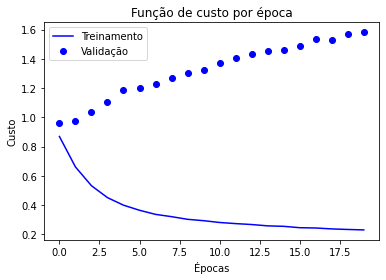

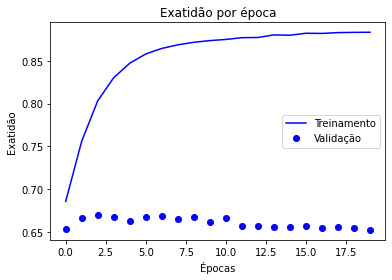

In [10]:
plt.plot(historico_pt.history['loss'], 'b', label='Treinamento')
plt.plot(historico_pt.history['val_loss'], 'bo', label='Validação')
plt.title('Função de custo por época')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

plt.plot(historico_pt.history['accuracy'], 'b', label='Treinamento')
plt.plot(historico_pt.history['val_accuracy'], 'bo', label='Validação')
plt.title('Exatidão por época')
plt.xlabel('Épocas')
plt.ylabel('Exatidão')
plt.legend()
plt.show()

Podemos analisar que o modelo deu overfit, onde ele melhora os resultados do modelo para o treino ao longo das épocas, mas piorando os o modelo para os dados de validação ao longo das épocas.

In [11]:
desempenho_treino_pt = modelo_pt.evaluate( BOW_x_treino_pt, y_treino_pt )
print('Valor da função de custo do treino = {0:.4f}\nValor da exatidão do treino = {1:.4f}'.format( desempenho_treino_pt[0], desempenho_treino_pt[1] ))

desempenho_validacao_pt = modelo_pt.evaluate( BOW_x_vali_pt, y_vali_pt )
print('Valor da função de custo da validação = {0:.4f}\nValor da exatidão da validação = {1:.4f}'.format( desempenho_validacao_pt[0], desempenho_validacao_pt[1] ))

desempenho_teste_pt = modelo_pt.evaluate( BOW_x_teste_pt, y_teste_pt )
print('Valor da função de custo do teste = {0:.4f}\nValor da exatidão do teste = {1:.4f}'.format( desempenho_teste_pt[0], desempenho_teste_pt[1] ))

2038/2038 [==============================] - 3s 1ms/step - loss: 0.1862 - accuracy: 0.9070
Valor da função de custo do treino = 0.1862
Valor da exatidão do treino = 0.9070
437/437 [==============================] - 1s 1ms/step - loss: 1.5818 - accuracy: 0.6525
Valor da função de custo da validação = 1.5818
Valor da exatidão da validação = 0.6525
437/437 [==============================] - 1s 1ms/step - loss: 1.6323 - accuracy: 0.6550
Valor da função de custo do teste = 1.6323
Valor da exatidão do teste = 0.6550


In [12]:
y_pred_pt = modelo_pt.predict( BOW_x_teste_pt )
y_pred_pt = np.round(y_pred_pt)

conf_matrix_pt = multilabel_confusion_matrix(y_teste_pt, y_pred_pt)
conf_matrix_pt

array([[[11129,   729],
        [  863,  1248]],

       [[10561,  1193],
        [ 1363,   852]],

       [[12714,   271],
        [  373,   611]],

       [[ 7649,  1083],
        [ 1189,  4048]],

       [[11199,   535],
        [  761,  1474]],

       [[12343,   439],
        [  580,   607]]])

In [13]:
# Legião Urbana - Tempo perdido
musica_teste_pt_rock = 'Todos os dias quando acordo Não tenho mais O tempo que passou Mas tenho muito tempo Temos todo o tempo do mundo Todos os dias Antes de dormir Lembro e esqueço Como foi o dia Sempre em frente Não temos tempo a perder Nosso suor sagrado É bem mais belo Que esse sangue amargo E tão sério E selvagem! Selvagem! Selvagem! Veja o sol Dessa manhã tão cinza A tempestade que chega É da cor dos teus olhos Castanhos Então me abraça forte E diz mais uma vez Que já estamos Distantes de tudo Temos nosso próprio tempo Temos nosso próprio tempo Temos nosso próprio tempo Não tenho medo do escuro Mas deixe as luzes Acesas agora O que foi escondido É o que se escondeu E o que foi prometido Ninguém prometeu Nem foi tempo perdido Somos tão jovens Tão jovens! Tão jovens!'

# Lexa - Amor bandido
musica_teste_pt_pop = 'Oh oh oh oh yeah yeah yeah yeah yeah yeah Lexa e Kekel Hitmaker Sei que você tá bolada Tá chateada e não quer me ouvir Dei umas escorregada Uma vacilada e me arrependi Mas to aqui, bebê Pedindo pra você voltar comigo Voltar comigo Eu te falei que não tinha perdão E pro meu coração já não dava mais Só que foi batendo a bad O corpo pede, voltei atrás Mas to aqui, bebê Sorrindo pra você voltar comigo Voltar comigo Voltar comigo Baby, eu não resisto a esse nosso amor bandido Quando você beija meu pescoço até o umbigo Volta pra cá que a saudade tá pedindo Baby, vem cá Baby, eu não resisto a esse nosso amor bandido Quando você beija meu pescoço até o umbigo Volta pra cá que a saudade tá pedindo Baby, vem cá Você sabe que é maldade Despertar minha insanidade To morrendo de vontade da sua boca Agora vê se não vacila Volta pra minha vida e vê se fica sem roupa Incrível como tudo se encaixa Em tudo o que a gente faz Indescritível o sentimento permanente que você me traz Baby, eu não resisto a esse nosso amor bandido Quando você beija meu pescoço até o umbigo Volta pra cá que a saudade tá pedindo Baby, vem cá Baby, eu não resisto a esse nosso amor bandido Quando você beija meu pescoço até o umbigo Volta pra cá que a saudade tá pedindo Baby, vem cá Eu to querendo mais Eu to querendo mais Cê tá querendo, eu to querendo Então como é que faz? Eu to querendo mais Eu to querendo mais Cê tá querendo, eu to querendo Então como é que faz? Eu to querendo mais Eu to querendo mais Cê tá querendo, eu to querendo Então como é que faz? Eu to querendo mais Eu to querendo mais Cê tá querendo Baby, eu não resisto a esse nosso amor bandido Quando você beija meu pescoço até o umbigo Volta pra cá que a saudade tá pedindo Baby, vem cá Eu to querendo mais Então como é que faz? Kekel e Lexa (yeah yeah yeah yeah)'

# 1Kilo - Deixe-me ir
musica_teste_pt_hiphop = 'Menina, me dá sua mão, pense bem antes de agir Se não for agora, te espero lá fora, então deixe-me ir Um dia te encontro nessas suas voltas Minha mente é mó confusão Solta a minha mão, que eu sei que cê volta O tempo mostra nossa direção Se eu soubesse que era assim, eu nem vinha Tô bebendo champanhe e catando latinha Mas tive que perder pra aprender dar valor Pra você entender seu amor, mas não quer ser mais minha Então diz que não me quer por perto Mas diz olhando nos meus olhos Desculpe se eu não fui sincero Mas a vida que eu levo, erros lógicos Óbvio, cada letra em rap é um código sórdido Psicografado som sólido, súbito Nunca fui de fazer som pra público Verso meu universo, peço que entenda meu mundo, mina A gente briga por bobeira demais A gente pira, o tempo vira por bobeira demais O amor é bandeira de paz Mas se não der, vai em paz, meto o pé Tô vivo e quero viver, ensinar e aprender Menina, eu sigo com ou sem você, mas tente entender Eu tentei, a vida é curta pra chorar pela ex Eu falei pra mim mesmo enquanto eu chorava outra vez, é Eu vou ficar, mas vou pela manhã Sem me despedir, vou antes do café Que é pra não te acordar, sei que não sou nenhum Don Juan Sou todo errado, mas tô certo que você me quer Eu vou ficar, mas vou pela manhã Sem me despedir, vou antes do café Que é pra não te acordar, sei que não sou nenhum Don Juan Sou todo errado, mas tô certo que você me quer Ei, amor, sei que tá tão difícil eu falar de amor Porque lá fora é tanto ódio e rancor Que eu preciso muito te falar Ei, amor, eu tô contigo independente do caô Cê sabe que aonde você for, eu vou E já passou da hora da gente se encontrar E se amar, nega, cê sabe que contigo nada vai me abalar A viagem é longa, então faça a mala Na vibe mais positiva, no pique mandala Esse papo de que se tu não existisse eu te inventaria é tão clichê Mas cai tão bem quando se trata de você Só vem comigo, cê não vai se arrepender Só vem comigo, cê não vai se arrepender Noites em claro, tentando não me envolver Seja o que deus quiser Noites em claro, tentando não me envolver Seja o que deus quiser, deixe-me ir Não vou me despedir porque dói Não vou brigar pra ficar Quero estar contigo e sentir, ser seu e só Sem ter que justificar o tempo em que eu sumi Seja o que deus quiser, deixe-me ir'

# Henrique & Juliano - Amor atual
musica_teste_pt_sertanejo = 'Você não pensou no meu amor Foi tão covarde Vivi um drama Vivendo na lama Já to indo tarde Não quero isso pra mim Não vou viver assim Eita, como dói Isso me destrói Mas eu vou te falar Você tá pensando o quê? Seu amor atual não tem culpa do anterior, bebê Tá pensando o quê? O que ele fez contigo, comigo cê quer fazer Você tá pensando o quê? Seu amor atual não tem culpa do anterior, bebê Tá pensando o quê? O que ele fez contigo, comigo cê quer fazer Pode esquecer Aí a pessoa briga com a pessoa E a pessoa quer brigar com a minha pessoa Tem jeito não, né Aí, não, né Você não pensou no meu amor Foi tão covarde Vivi um drama Vivendo na lama Já to indo tarde Não quero isso pra mim Não vou viver assim Eita, como dói Isso me destrói Mas eu vou te falar Você tá pensando o quê? Seu amor atual não tem culpa do anterior, bebê Tá pensando o quê? O que ele fez contigo, comigo cê quer fazer Você tá pensando o quê? Seu amor atual não tem culpa do anterior, bebê Tá pensando o quê? O que ele fez contigo, comigo cê quer fazer Pode esquecer Você tá pensando o quê? Seu amor atual não tem culpa do anterior, bebê Tá pensando o quê? O que ele fez contigo, comigo cê quer fazer Você tá pensando o quê? Seu amor atual não tem culpa do anterior, bebê Tá pensando o quê? O que ele fez contigo, comigo cê quer fazer Pode esquecer'

# Martinho Da Vila - Casa de Bamba
musica_teste_pt_samba = 'Na minha casa Todo mundo é bamba Todo mundo bebe Todo mundo samba Na minha casa Todo mundo é bamba Todo mundo bebe Todo mundo samba Na minha casa Não tem bola pra vizinha Não se fala do alheio Nem se liga pra candinha Na minha casa Não tem bola pra vizinha Não se fala do alheio Nem se liga pra candinha Na minha casa Todo mundo é bamba Todo mundo bebe Todo mundo samba Na minha casa Todo mundo é bamba Todo mundo bebe Todo mundo samba Na minha casa Ninguém liga pra intriga Todo mundo xinga Todo mundo briga Na minha casa Ninguém liga prá intriga Todo mundo xinga Todo mundo briga Macumba lá na minha casa Tem galinha preta Azeite de dendê Mas ladainha lá na minha casa Tem reza bonitinha E canjiquinha pra comer Mas ladainha lá na minha casa Tem reza bonitinha E canjiquinha pra comer Se tem alguém aflito Todo mundo chora Todo mundo sofre Mas logo se reza Pra São Benedito Pra Nossa Senhora E pra Santo Onofre Mas se tem alguém cantando Todo mundo canta Todo mundo dança Todo mundo samba E ninguém se cansa Pois minha casa É casa de bamba Pois minha casa É casa de bamba Macumba lá na minha casa Tem galinha preta Azeite de dendê Mas ladainha lá na minha casa Tem reza bonitinha E canjiquinha prá comer Mas ladainha lá na minha casa Tem reza bonitinha E canjiquinha pra comer Se tem alguém aflito Todo mundo chora Todo mundo sofre Mas logo se reza Pra São Benedito Pra Nossa Senhora E pra Santo Onofre Mas se tem alguém cantando Todo mundo canta Todo mundo dança Todo mundo samba E ninguém se cansa Pois minha casa É casa de bamba Pois minha casa É casa de bamba Pois minha casa É casa de bamba'

# MC Ingryd - Vem Me Satisfazer
musica_teste_pt_funk = 'Marca pra nós se ver Pode ser pra ferver Hoje eu quero você Vem me satisfazer No teu jeito que eu me amarro De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo Te avisei, não se envolve no meu papo Não passou de um boato pra você enlouquecer Eu te dei prazer, tu pediu prazer Agora o que eu posso fazer? Eu não quero mais você Quem falou que eu quero ser tua mulher? Toma vergonha na cara e vê se larga do meu pé Muito louca na onda do Goldin Chamei os cria pra base Vai rolar chuva de lean De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo Marca pra nós se ver Pode ser pra ferver Hoje eu quero você Vem me satisfazer No teu jeito que eu me amarro De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo Te avisei, não se envolve no meu papo Não passou de um boato pra você enlouquecer Eu te dei prazer, tu pediu prazer Agora o que eu posso fazer? Eu não quero mais você Quem falou que eu quero ser tua mulher? Toma vergonha na cara e vê se larga do meu pé Muito louca na onda do Goldin Chamei os cria pra base Vai rolar chuva de lean De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo'

lista_musicas_teste_pt = [ musica_teste_pt_rock, musica_teste_pt_pop, musica_teste_pt_hiphop, musica_teste_pt_sertanejo, musica_teste_pt_samba, musica_teste_pt_funk ]

teste_pt = vectorizer_pt.transform( lista_musicas_teste_pt ).toarray()
saida_teste_pt = modelo_pt.predict( teste_pt )
saida_teste_mex_pt = np.argmax( saida_teste_pt, axis=1 )
saida_teste_traducao_pt = [dataset_generos_rev.get(item,item) for item in saida_teste_mex_pt]

for i in range( quantidade_generos_pt ):
    print('Música de {0} o modelo preveu {1}'.format( list(dataset_generos.keys())[i], saida_teste_traducao_pt[i] ))

Música de Rock o modelo preveu Pop
Música de Pop o modelo preveu Pop
Música de Hip Hop o modelo preveu Pop
Música de Sertanejo o modelo preveu Funk Carioca
Música de Samba o modelo preveu Samba
Música de Funk Carioca o modelo preveu Funk Carioca


Vamos analisar que palavras tem maior peso na analise do resultado para o modelo.

In [14]:
primeira_camada_pt = modelo_pt.layers[0].name
somatoria_pesos_pt = np.sum(modelo_pt.get_layer( primeira_camada_pt ).get_weights()[0], axis=1)

df_vetor_palavras_pt = pd.DataFrame.from_dict(vectorizer_pt.vocabulary_, orient='index', columns=['numero'])
df_vetor_palavras_pt['peso'] = somatoria_pesos_pt

df_vetor_palavras_pt.sort_values(by=['peso'], ascending=False)

,numero,peso
closing,10255,50.323399
lásó,27668,49.250191
lambrett,26319,47.354076
amorpel,2906,44.917393
antár,3309,43.207836
...,...,...
alguémcol,2222,-19.851274
tayl,43754,-21.284807
sabendosó,40287,-21.721247
fischer,19790,-22.212563


#EN

In [ ]:
print('{0} -> inicio'.format(datetime.now() - timedelta(hours = 3)))
inicio = time.time()

letras_en_agrupado = ''
for i in range( dataset_en.shape[0] ):
    letras_en_agrupado += dataset_en.iloc[i]['Lyric']

w_token_en = word_tokenize( letras_en_agrupado )

print('{0} -> fim , levou {1:.2f}s'.format(datetime.now() - timedelta(hours = 3), time.time() - inicio))

In [ ]:
print('{0} -> inicio'.format(datetime.now() - timedelta(hours = 3)))
inicio = time.time()

stw_en = stopwords.words('english')
pontuacao = list( punctuation )
stopwords_en = set( stw_en + pontuacao ) #cria lista sem repetir elementos
w_token_en_sem_stopwords = [palavra for palavra in w_token_en if palavra not in stopwords_en]

stemmer = RSLPStemmer()
w_token_en_sem_stopwords_stem = [stemmer.stem( palavra ) for palavra in w_token_en_sem_stopwords]

print('{0} -> fim , levou {1:.2f}s'.format(datetime.now() - timedelta(hours = 3), time.time() - inicio))

In [ ]:
print('{0} -> inicio'.format(datetime.now() - timedelta(hours = 3)))
inicio = time.time()

vectorizer_en = CountVectorizer( analyzer='word' )
vectorizer_en.fit( w_token_en_sem_stopwords_stem )
tamanho_dicionario_en = len(list(vectorizer_en.vocabulary_))

letras_en = dataset_en['Lyric'].values #X
generos_en = dataset_en['NR_Genre'].values #Y

generos_en_dummy = np_utils.to_categorical(generos_en)

x_treino_en, x_teste_en, y_treino_en, y_teste_en = train_test_split( letras_en, generos_en_dummy, test_size=0.3, random_state=42 )
x_vali_en, x_teste_en, y_vali_en, y_teste_en = train_test_split( x_teste_en, y_teste_en, test_size=0.5, random_state=42 )

BOW_x_treino_en = vectorizer_en.transform( x_treino_en )
BOW_x_vali_en = vectorizer_en.transform( x_vali_en )
BOW_x_teste_en = vectorizer_en.transform( x_teste_en )

print('{0} -> fim , levou {1:.2f}s'.format(datetime.now() - timedelta(hours = 3), time.time() - inicio))

In [ ]:
modelo_en = Sequential()

modelo_en.add( Dense( 128, activation='relu', input_shape=(tamanho_dicionario_en,) ) )
modelo_en.add( Dense( quantidade_generos_en, activation='softmax' ) )

modelo_en.compile( Adam(), loss='categorical_crossentropy', metrics=['accuracy'] )

modelo_en.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               16552320  
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 16,552,707
Trainable params: 16,552,707
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historico_en = modelo_en.fit( BOW_x_treino_en, y_treino_en, epochs=50, validation_data=( BOW_x_vali_en, y_vali_en ) )

Epoch 1/50
2713/2713 [==============================] - 167s 62ms/step - loss: 0.7210 - accuracy: 0.6784 - val_loss: 0.6803 - val_accuracy: 0.6893
Epoch 2/50
2713/2713 [==============================] - 167s 62ms/step - loss: 0.5835 - accuracy: 0.7323 - val_loss: 0.6659 - val_accuracy: 0.6969
Epoch 3/50
2713/2713 [==============================] - 167s 61ms/step - loss: 0.4985 - accuracy: 0.7719 - val_loss: 0.6863 - val_accuracy: 0.6998
Epoch 4/50
2713/2713 [==============================] - 164s 60ms/step - loss: 0.4344 - accuracy: 0.8015 - val_loss: 0.7393 - val_accuracy: 0.6914
Epoch 5/50
2713/2713 [==============================] - 164s 61ms/step - loss: 0.3858 - accuracy: 0.8237 - val_loss: 0.7816 - val_accuracy: 0.6945
Epoch 6/50
2713/2713 [==============================] - 164s 60ms/step - loss: 0.3555 - accuracy: 0.8379 - val_loss: 0.8231 - val_accuracy: 0.6909
Epoch 7/50
2713/2713 [==============================] - 164s 60ms/step - loss: 0.3309 - accuracy: 0.8474 - val_loss: 0

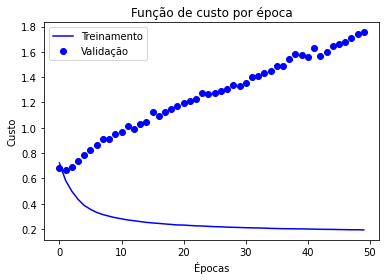

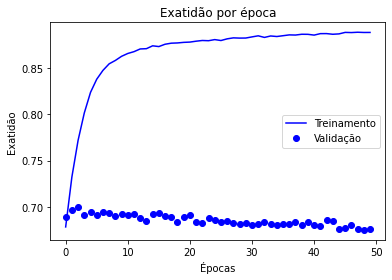

In [ ]:
plt.plot(historico_en.history['loss'], 'b', label='Treinamento')
plt.plot(historico_en.history['val_loss'], 'bo', label='Validação')
plt.title('Função de custo por época')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

plt.plot(historico_en.history['accuracy'], 'b', label='Treinamento')
plt.plot(historico_en.history['val_accuracy'], 'bo', label='Validação')
plt.title('Exatidão por época')
plt.xlabel('Épocas')
plt.ylabel('Exatidão')
plt.legend()
plt.show()

In [ ]:
desempenho_treino_en = modelo_en.evaluate( BOW_x_treino_en, y_treino_en )
print('Valor da função de custo do treino = {0:.4f}\nValor da exatidão do treino = {1:.4f}'.format( desempenho_treino_en[0], desempenho_treino_en[1] ))

desempenho_validacao_en = modelo_en.evaluate( BOW_x_vali_en, y_vali_en )
print('Valor da função de custo da validação = {0:.4f}\nValor da exatidão da validação = {1:.4f}'.format( desempenho_validacao_en[0], desempenho_validacao_en[1] ))

desempenho_teste_en = modelo_en.evaluate( BOW_x_teste_en, y_teste_en )
print('Valor da função de custo do teste = {0:.4f}\nValor da exatidão do teste = {1:.4f}'.format( desempenho_teste_en[0], desempenho_teste_en[1] ))

2713/2713 [==============================] - 4s 1ms/step - loss: 0.1734 - accuracy: 0.9016
Valor da função de custo do treino = 0.1734
Valor da exatidão do treino = 0.9016
582/582 [==============================] - 1s 1ms/step - loss: 1.7547 - accuracy: 0.6761
Valor da função de custo da validação = 1.7547
Valor da exatidão da validação = 0.6761
582/582 [==============================] - 1s 1ms/step - loss: 1.6874 - accuracy: 0.6748
Valor da função de custo do teste = 1.6874
Valor da exatidão do teste = 0.6748


In [ ]:
y_pred_en = modelo_en.predict( BOW_x_teste_en )
y_pred_en = np.round(y_pred_en)

conf_matrix_en = multilabel_confusion_matrix(y_teste_en, y_pred_en)
conf_matrix_en

array([[[ 7236,  2281],
        [ 1780,  7302]],

       [[10204,  2373],
        [ 3117,  2905]],

       [[13915,  1189],
        [ 1312,  2183]]])

In [ ]:
# Linkin Park - Numb
musica_teste_en_rock = "I'm tired of being what you want me to be Feeling so faithless, lost under the surface I don't know what you're expecting of me Put under the pressure of walking in your shoes Caught in the undertow, just caught in the undertow Every step that I take is another mistake to you Caught in the undertow, just caught in the undertow I've become so numb, I can't feel you there Become so tired, so much more aware By becoming this all I want to do Is be more like me and be less like you Can't you see that you're smothering me? Holding too tightly, afraid to lose control 'Cause everything that you thought I would be Has fallen apart right in front of you Caught in the undertow, just caught in the undertow Every step that I take is another mistake to you Caught in the undertow, just caught in the undertow And every second I waste is more than I can take! I've become so numb, I can't feel you there Become so tired, so much more aware By becoming this all I want to do Is be more like me and be less like you And I know I may end up failing too But I know you were just like me with someone disappointed in you I've become so numb, I can't feel you there Become so tired, so much more aware By becoming this all I want to do Is be more like me and be less like you I've become so numb, I can't feel you there I'm tired of being what you want me to be I've become so numb, I can't feel you there I'm tired of being what you want me to be"

# Lady Gaga - Poker Face
musica_teste_en_pop = "Mum-mum-mum-mah Mum-mum-mum-mah Mum-mum-mum-mah Mum-mum-mum-mah Mum-mum-mum-mah I wanna hold 'em like they do in Texas, please Fold 'em, let 'em hit me, raise it, baby, stay with me (I love it) Love game intuition, play the cards with spades to start And after he's been hooked, I'll play the one that's on his heart Oh, whoa, oh, oh Oh, oh oh I'll get him hot, show him what I've got Oh, whoa, oh, oh Oh, oh oh I'll get him hot, show him what I've got Can't read my, can't read my No, he can't read my poker face (She's got me like nobody) Can't read my, can't read my No, he can't read my poker face (She's got me like nobody) P-p-p-poker face, p-p-poker face (mum-mum-mum-mah) P-p-p-poker face, p-p-poker face (mum-mum-mum-mah) I wanna roll with him, a hard pair we will be (hey) A little gamblin' is fun when you're with me (I love it) Russian roulette is not the same without a gun And baby, when it's love, if it's not rough, it isn't fun (fun) Oh, whoa, oh, oh Oh, oh oh I'll get him hot, show him what I've got Oh, whoa, oh, oh Oh, oh oh I'll get him hot, show him what I've got Can't read my, can't read my No, he can't read my poker face (She's got me like nobody) Can't read my, can't read my No, he can't read my poker face (She's got me like nobody) P-p-p-poker face, p-p-poker face (mum-mum-mum-mah) P-p-p-poker face, p-p-poker face (mum-mum-mum-mah) (Mum-mum-mum-mah) (Mum-mum-mum-mah) I won't tell you that I love you, kiss or hug you 'Cause I'm bluffin' with my muffin I'm not lying, I'm just stunnin' with my love-glue-gunnin' Just like a chick in the casino Take your bank before I pay you out I promise this, promise this Check this hand 'cause I'm marvelous Can't read my, can't read my No, he can't read my poker face (She's got me like nobody) Can't read my, can't read my No, he can't read my poker face (She's got me like nobody) Can't read my, can't read my No, he can't read my poker face (She's got me like nobody) Can't read my, can't read my No, he can't read my poker face (She's got me like nobody) Can't read my, can't read my No, he can't read my poker face (She's got me like nobody) Can't read my, can't read my No, he can't read my poker face (She's got me like nobody) P-p-p-poker face, p-p-poker face P-p-p-poker face, p-p-poker face (She's got me like nobody) P-p-p-poker face, p-p-poker face (mum-mum-mum-mah) P-p-p-poker face, p-p-poker face (mum-mum-mum-mah) P-p-p-poker face, p-p-poker face (mum-mum-mum-mah) P-p-p-poker face, p-p-poker face (mum-mum-mum-mah)"

# Akon - Lonely
musica_teste_en_hiphop = "Lonely, I'm Mr. Lonely I have nobody for my own Oh, I'm so lonely I'm Mr. Lonely I have nobody for my own Oh, I'm so lonely Yo, this one here Goes out to all my players out there, man You know, that got that one good girl, dogg That's always been there, man Like, took all the bullshit But then one day she can't take it no more And decide to leave Yeah, I woke up in the middle of the night And I noticed my girl wasn't by my side Could've sworn I was dreamin' For her I was feenin' So I had to take a little ride Backtrackin' on these few years Tryna figure out what I do to make it go bad 'Cause ever since my girl left me My whole life came crashin', and I'm so Lonely (so lonely) I'm Mr. Lonely (Mr. Lonely) I have nobody (I have nobody) For my own (to call my own) girl Oh, I'm so lonely (so lonely) I'm Mr. Lonely (Mr. Lonely) I have nobody (I have nobody) For my own (to call my own) girl Oh, I'm so lonely Can't believe I had a girl like you And I just let you walk right out of my life After all I put you through You still stuck around and stayed by my side What really hurt me is I broke your heart Baby, you a good girl and I had no right I really wanna to make things right 'Cause without you in my life girl, I'm so Lonely (so lonely) I'm Mr. Lonely (Mr. Lonely) I have nobody (I have nobody) For my own (to call my own) girl Oh, I'm so lonely (so lonely) I'm Mr. Lonely (Mr. Lonely) I have nobody (I have nobody) For my own (to call my own, baby) Oh, I'm so lonely Been all over the world Ain't never met a girl That could take the things that you been through Never thought the day would come Where you would get up and run And I would be out chasin' you 'Cause ain't nowhere in the globe I'd rather be Ain't no one in the globe I'd rather see Than the girl of my dreams that made me be So happy, but now so lonely Lonely (so lonely) I'm Mr. Lonely (Mr. Lonely) I have nobody (I have nobody) For my own (to call my own) girl Oh, I'm so lonely (so lonely) I'm Mr. Lonely (Mr. Lonely) I have nobody (I have nobody) For my own (to call my own, baby) Oh, I'm so lonely Never thought that I'd be alone I didn't think you'd be gone this long I just want you to call my phone So stop playing girl and come on home (come on home) Baby girl I didn't mean to shout I want me and you to work it out I never wished to ever hurt my baby And it's drivin' me crazy, 'cause I'm so Lonely (so lonely) I'm Mr. Lonely (Mr. Lonely) I have nobody (I have nobody) For my own (to call my own) girl Oh, I'm so lonely (so lonely) I'm Mr. Lonely (Mr. Lonely) I have nobody (I have nobody) For my own (to call my own, baby) Oh, I'm so lonely So lonely, so lonely Mr. Lonely, so lonely So lonely, so lonely So lonely, Mr. Lonely"

lista_musicas_teste_en = [ musica_teste_en_rock, musica_teste_en_pop, musica_teste_en_hiphop ]

teste_en = vectorizer_en.transform( lista_musicas_teste_en ).toarray()
saida_teste_en = modelo_en.predict( teste_en )
saida_teste_mex_en = np.argmax( saida_teste_en, axis=1 )
saida_teste_traducao_en = [dataset_generos_rev.get(item,item) for item in saida_teste_mex_en]

for i in range( quantidade_generos_en ):
    print('Música de {0} o modelo preveu {1}'.format( list(dataset_generos.keys())[i], saida_teste_traducao_en[i] ))

Música de Rock o modelo preveu Rock
Música de Pop o modelo preveu Pop
Música de Hip Hop o modelo preveu Pop


In [ ]:
primeira_camada_en = modelo_en.layers[0].name
somatoria_pesos_en = np.sum(modelo_en.get_layer( primeira_camada_en ).get_weights()[0], axis=1)

df_vetor_palavras_en = pd.DataFrame.from_dict(vectorizer_en.vocabulary_, orient='index', columns=['numero'])
df_vetor_palavras_en['peso'] = somatoria_pesos_en

df_vetor_palavras_en.sort_values(by=['peso'], ascending=False)

,numero,peso
offbeat,79877,79.274055
game,44743,69.616493
jcarlosthil,59382,68.311104
grime,48481,67.685822
perkul,85242,67.650497
...,...,...
kaset,61116,-50.787788
splurging,105298,-52.086670
pimin,86182,-56.059128
werenâ,122899,-59.531796


In [ ]:
modelo_pt.save_weights( caminho_drive + 'modelo_pt_{0}.h5'.format( agora ) )
modelo_en.save_weights( caminho_drive + 'modelo_en_{0}.h5'.format( agora ) )

#TESTAR
- Support Vector Machines
- Bayesian Networks
- Maximum Entropy
- Conditional Random Field
- Neural Networks/Deep Learning
- XGBoost

#Utilizar sklearn

In [ ]:
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn import svm

from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import f1_score

In [ ]:
x_treino_pt, x_teste_pt, y_treino_pt, y_teste_pt = train_test_split( letras_pt, generos_pt, test_size=0.3, random_state=42 )
x_vali_pt, x_teste_pt, y_vali_pt, y_teste_pt = train_test_split( x_teste_pt, y_teste_pt, test_size=0.5, random_state=42 )

In [ ]:
nb_pt = MultinomialNB()
nb_pt.fit( BOW_x_treino_pt, y_treino_pt )

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
predicao_treino_pt = nb_pt.predict( BOW_x_treino_pt )
predicao_vali_pt = nb_pt.predict( BOW_x_vali_pt )
predicao_teste_pt = nb_pt.predict( BOW_x_teste_pt )

print( f1_score( y_treino_pt, predicao_treino_pt, average='weighted' ) )
print( f1_score( y_vali_pt, predicao_vali_pt, average='weighted' ) )
print( f1_score( y_teste_pt, predicao_teste_pt, average='weighted' ) )

0.6273797806353383
0.5839240603163042
0.5846584227196335


In [ ]:
svm_pt = svm.SVC()
svm_pt.fit( BOW_x_treino_pt, y_treino_pt )

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
predicao_treino_pt = svm_pt.predict( BOW_x_treino_pt )
predicao_vali_pt = svm_pt.predict( BOW_x_vali_pt )
predicao_teste_pt = svm_pt.predict( BOW_x_teste_pt )

print( f1_score( y_treino_pt, predicao_treino_pt, average='weighted' ) )
print( f1_score( y_vali_pt, predicao_vali_pt, average='weighted' ) )
print( f1_score( y_teste_pt, predicao_teste_pt, average='weighted' ) )

0.7279094843827587
0.613097031279735
0.6109263912710139


In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer

clf = OneVsRestClassifier(XGBClassifier(n_jobs=-1, max_depth=4))

mlb = MultiLabelBinarizer()

clf.fit( BOW_x_treino_pt, y_treino_pt )

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=4, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=-1, nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
                    n_jobs=None)

In [ ]:
predicao_treino_pt = clf.predict( BOW_x_treino_pt )
predicao_vali_pt = clf.predict( BOW_x_vali_pt )
predicao_teste_pt = clf.predict( BOW_x_teste_pt )

print( f1_score( y_treino_pt, predicao_treino_pt, average='weighted' ) )
print( f1_score( y_vali_pt, predicao_vali_pt, average='weighted' ) )
print( f1_score( y_teste_pt, predicao_teste_pt, average='weighted' ) )

0.3856007499167081
0.3704527039463678
0.37171248572911636


In [ ]:
xgb_clf = xgb.XGBClassifier(learning_rate = 0.01,
                         max_depth = 10, 
                         n_estimators = 1000,
                         objective = 'binary:logistic',
                         verbosity =0,
                         seed = 42,
                         reg_lambda = 8,
                         reg_alpha = 2,
                         gamma = 5,
                         subsample= 0.8,
                         #tree_method = 'gpu_hist'
                         )
xgb_clf.fit( BOW_x_treino_pt, y_treino_pt )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=2, reg_lambda=8, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, verbosity=0)

In [ ]:
predicao_treino_pt = xgb_clf.predict( BOW_x_treino_pt )
predicao_vali_pt = xgb_clf.predict( BOW_x_vali_pt )
predicao_teste_pt = xgb_clf.predict( BOW_x_teste_pt )

print( f1_score( y_treino_pt, predicao_treino_pt, average='weighted' ) )
print( f1_score( y_vali_pt, predicao_vali_pt, average='weighted' ) )
print( f1_score( y_teste_pt, predicao_teste_pt, average='weighted' ) )

0.6302667054432052
0.5761223215723886
0.5770302598162361
